In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats 
sns.set(style="whitegrid")


%matplotlib inline

<h1>Take Home Assigment : Listening Sessions</h1>

<h2>Dataset Description</h2>
<ul>                                                                                         
    <li>end_song_sample.csv</li>
    <ul>
        <li><b>ms_played</b> -- the amount of time the user listened to this track, in milliseconds         </li>
        <li><b>context</b> -- the UI context the track was played from (e.g. playlist or artist page)       </li>
        <li><b>track_id</b> -- the random UUID for the track                                                </li>
        <li><b>product</b> -- the product status (e.g. free or paid)                                        </li>
        <li><b>end_timestamp</b> -- the Epoch timestamp that marks the end of the listen                    </li>
        <li><b>user_id</b> -- the anonymous, random UUID of the user                                        </li>
    </ul>
    <li>user_data_sample.csv</li>
    <ul>
        <li><b>gender</b> -- the gender of the user (male or female)                                        </li>
        <li><b>age_range</b> -- a bucketed age of the user                                                  </li>
        <li><b>country</b> -- the country where the user registered                                         </li>
        <li><b>acct_age_weeks</b> -- the age of the user's account in weeks as of Oct 14th, 2015            </li>
        <li><b>user_id</b> -- the anonymous, random UUID of the user                                        </li>
    </ul>
</ul>

<h2>Read the data</h2>

In [2]:
users = pd.read_csv("user_data_sample.csv")
songs = pd.read_csv("end_song_sample.csv")
data = songs.merge(users, how='inner', on='user_id')

In [3]:
data.describe()

,ms_played,end_timestamp,acct_age_weeks
count,1.342891e+06,1.342891e+06,1.342891e+06
mean,1.287120e+05,1.444270e+09,7.936324e+01
std,1.200548e+05,3.518090e+05,7.656259e+01
min,0.000000e+00,1.443658e+09,-1.000000e+00
25%,3.778000e+03,1.443964e+09,1.900000e+01
50%,1.476780e+05,1.444272e+09,5.500000e+01
75%,2.228010e+05,1.444574e+09,1.210000e+02
max,5.100017e+06,1.444867e+09,3.630000e+02


<h1>Define listening sessions</h1>

In [4]:
import datetime

data['start_timestamp'] = (data['end_timestamp']*1000 - data['ms_played'])/1000.0

#Convert timestamps to date
data['start_date'] = data['start_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
                                                                                     
data['end_date'] = data['end_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
 

<h2>Exploration on a specific user</h2>

In [5]:
#Find the user with the mosts tracks listened
user_count_tracks = data.groupby(['user_id'], as_index=False).agg({'track_id':'count'})
user_count_tracks.columns = ['user_id', 'count_tracks']

user_count_tracks = user_count_tracks.sort_values("count_tracks", ascending=False)

max_tracks_listened = user_count_tracks.count_tracks.max()
user_star_id = user_count_tracks[user_count_tracks.count_tracks ==  max_tracks_listened]['user_id'].values[0]
print('The user id of the user with the most tracks listened is', user_star_id, 'and he has listened', max_tracks_listened, 'tracks')
user_count_tracks.head()

The user id of the user with the most tracks listened is 8d758d1cf1ae4a6aac3ada5576b4fc25 and he has listened 4409 tracks


,user_id,count_tracks
5280,8d758d1cf1ae4a6aac3ada5576b4fc25,4409
7788,d10c8673c24048edb5ab72cfdc803b34,3869
62,01d7789847e9489aaca7230b8cf7f145,3471
7638,cd21473103fc4fe987008baa2060fea0,3374
1552,289d885bb40f4d84b8499e879fa080a1,3308


In [6]:
data_star = data[data.user_id == user_star_id]
print(len(data_star),'Tracks on the dataframe before')
#We take a sample of the data (8 hours)
data_star = data_star[(data_star.start_date > '2015-10-14 07:00:00') & (data_star.start_date < '2015-10-14 15:00:00')]

print(len(data_star),'Tracks on the dataframe after')
data_star = data_star.sort('start_timestamp', ascending=True)

4409 Tracks on the dataframe before
258 Tracks on the dataframe after


C:\Users\i327247\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


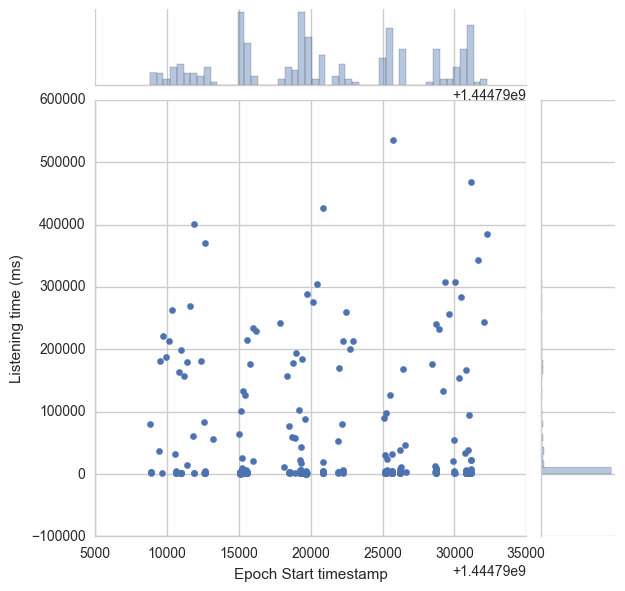

In [7]:
sns.jointplot(x="start_timestamp", y="ms_played", data=data_star,stat_func=None, marginal_kws=dict(bins=50, rug=False)).set_axis_labels("Epoch Start timestamp", "Listening time (ms)")

For this user We can see that we have <b>5</b> differents listening sessions (maybe <b>6</b> with the blue one, it's gonna depend of the definition of a session) with differents duration for the 8 hours time period we choosed to study.<br/>
<img src="./session_breakdown.JPG">

Let's assume that all others users have the same listening behavior, meaning that their overall listening can be separate in sessions.<br/>
Let's now define what the hell it's a Session.

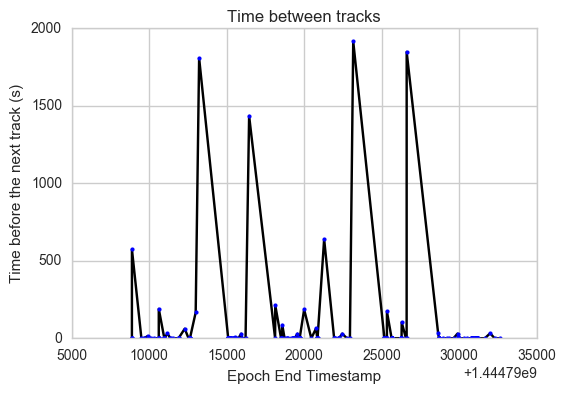

In [8]:
#Let's see the distribution of the time gap between two consecutives tracks

data_star['wait_time'] = np.zeros(len(data_star))

prev_row = None
for row in data_star.itertuples():
    if (prev_row != None) :
        wait_time = np.abs(row.start_timestamp - prev_row.end_timestamp)
        data_star.set_value(prev_row.Index, 'wait_time', wait_time)
        prev_row = row
    else :
        prev_row = row

plt.plot(data_star['end_timestamp'], data_star['wait_time'], '-', 
         marker='o',  markersize=3,  markerfacecolor='blue', color ='black')
plt.xlabel("Epoch End Timestamp")
plt.ylabel("Time before the next track (s)")
plt.title("Time between tracks")


Yeaaah !! We can clearly see the listening sessions we found earlier represented by the 6 peaks on the curve.<br />
When the curve goes very high, it means there is a lot of time between two tracks. So those peaks represents the separation between sessions.<br/>
The peak at the start indicates that the users has just finished a listening session : remember that we took a 8 hour sample of the data. So we can assume that the beginning of a sample was the end of one of his listening session.
<img src="./session_breakdown_wait_time.JPG">

Graphically we can see the peaks, for this one i decided that when the wait time is greater than <b>500 ms</b>, it's the end of a session. 500ms cause it looks like a good threshold in this case. But let's remember this is just a sample. Others users may have a different wait time distribution. So instead of using a wait time treshold which might change a lot from one user to another, i'm going to use a statiscal indicator called <b>Z-Score</b>.<br/>
The <b>Z-Score</b> is a numerical measurement of a value's relationship to the mean in a group of values. If a Z-score is 0, it represents the score is identical to the mean score. It allows you to identifie the outliers on a distribution and in our case we are only interested in those outliers

Z-Score = (value - mean)/std

Instead of a treshold on the wait time. I use a treshold on the Z-Score. 
I choose <b>Z-Score_treshold = 2</b>

In [9]:
zscore_th = 3

In [10]:
data_star['zscore'] = stats.zscore(data_star['wait_time'])

data_star['session_id'] = 0

current_session_id = 0

for row in data_star.itertuples() :
    data_star.set_value(row.Index ,'session_id', current_session_id)
    if (row.zscore > zscore_th) :
        current_session_id += 1

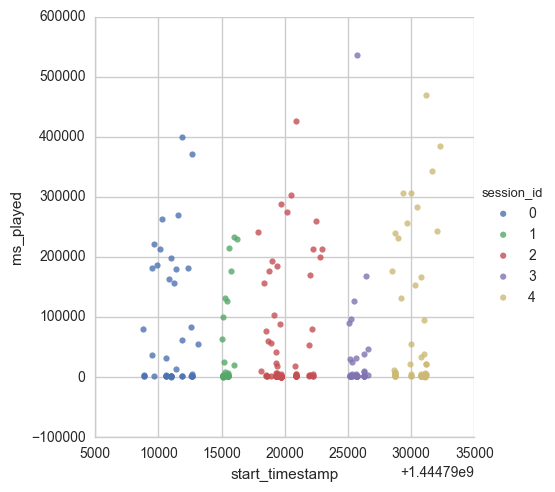

In [11]:
sns.lmplot("start_timestamp", "ms_played", data=data_star, hue='session_id', fit_reg=False)

We managed to define what is a session and detect them for a specific user on a specific time period. Let's now apply this on the whole dataset.

<h2>Sessions for all</h2>

In [12]:
user_id_list = list(data.user_id.unique())

print('There is', len(user_id_list), 'unique users')

There is 9565 unique users


In [13]:
#Let's create the sessions dataframe
df_sessions = pd.DataFrame(columns=['session_id', 'user_id', 'start_timestamp','start_date', 'duration'])

In [14]:
#For every user let's compute all his sessions

data['session_id'] = -1
zscore_th = 3

current_session_id = 0
for user_id in user_id_list :
    tracks_user = data[data.user_id == user_id]
    
    #Compute the wait_time
    tracks_user['wait_time'] = 0
    prev_row = None
    for row in tracks_user.itertuples():
        if (prev_row != None) :
            wait_time = np.abs(row.start_timestamp - prev_row.end_timestamp)
            tracks_user.set_value(prev_row.Index, 'wait_time', wait_time)
            prev_row = row
        else :
            prev_row = row
    
    #Compute the Z-Score
    tracks_user['zscore'] = stats.zscore(tracks_user['wait_time'])
    
    for row in tracks_user.itertuples() :
        data.set_value(row.Index ,'session_id', current_session_id)
        if (row.zscore > zscore_th) :
            current_session_id += 1
    
    e = user_id_list.index(user_id)
    if(e%100 == 0):
        print(e,'/9565')
    #When we finish with an user we increment the session_id        
    current_session_id += 1


C:\Users\i327247\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\i327247\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 /9565
100 /9565
200 /9565
300 /9565
400 /9565
500 /9565
600 /9565
700 /9565
800 /9565
900 /9565
1000 /9565
1100 /9565
1200 /9565
1300 /9565
1400 /9565
1500 /9565
1600 /9565
1700 /9565
1800 /9565
1900 /9565
2000 /9565
2100 /9565
2200 /9565
2300 /9565
2400 /9565
2500 /9565
2600 /9565
2700 /9565
2800 /9565
2900 /9565
3000 /9565
3100 /9565
3200 /9565
3300 /9565
3400 /9565
3500 /9565
3600 /9565
3700 /9565
3800 /9565
3900 /9565
4000 /9565
4100 /9565
4200 /9565
4300 /9565
4400 /9565
4500 /9565
4600 /9565
4700 /9565
4800 /9565
4900 /9565
5000 /9565
5100 /9565
5200 /9565
5300 /9565
5400 /9565
5500 /9565
5600 /9565
5700 /9565
5800 /9565
5900 /9565
6000 /9565
6100 /9565
6200 /9565
6300 /9565
6400 /9565
6500 /9565
6600 /9565
6700 /9565
6800 /9565
6900 /9565
7000 /9565
7100 /9565
7200 /9565
7300 /9565
7400 /9565
7500 /9565
7600 /9565
7700 /9565
7800 /9565
7900 /9565
8000 /9565
8100 /9565
8200 /9565
8300 /9565
8400 /9565
8500 /9565
8600 /9565
8700 /9565
8800 /9565
8900 /9565
9000 /9565
9100 /9565


In [15]:
data.to_csv('all_data_session_breakdown_zscore_3.csv')

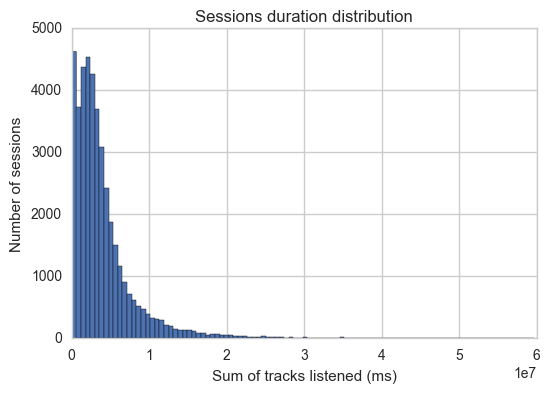

In [16]:
#Listening per session
sessions_duration = data.groupby(['session_id', 'gender'], as_index=False).agg({"ms_played":"sum"})
sessions_duration.columns = ['session_id', 'gender', 'sum_ms_played']

sessions_duration.sum_ms_played.hist(bins=100)
plt.xlabel('Sum of tracks listened (ms)')
plt.ylabel('Number of sessions')
plt.title('Sessions duration distribution')

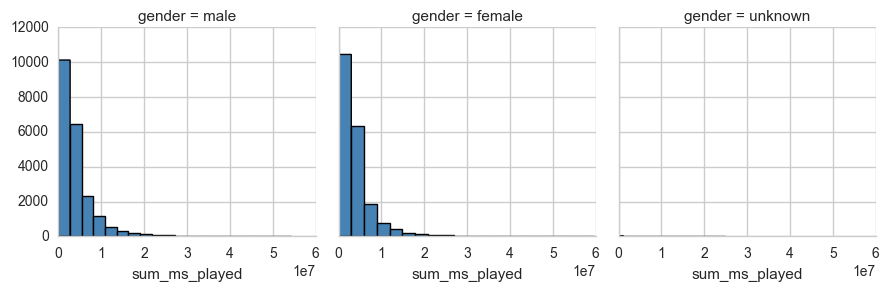

In [17]:
g = sns.FacetGrid(sessions_duration, col="gender", margin_titles=True)
bins = np.linspace(0, 1e8, 40)
g.map(plt.hist, "sum_ms_played", color="steelblue", bins=20, lw=1)

In [18]:
dqsdqsdsd[['aaa', 'addd', 'ffdffsq']]

NameError: name 'dqsdqsdsd' is not defined